In [7]:
#Packages
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

#Data
df = pd.read_csv('Monthly_Macroeconomic_Factors.csv')

# make date index a datetime object
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True) # set the date as the index

#Model with all variables
formula = 'House_Price_Index ~ ' + ' + '.join(
    df.columns.difference(['House_Price_Index'])) #get all the columns except for the house price index

model = smf.ols(formula, data=df)
results = model.fit()

print(results.summary())

#Check for autocorrelation, heteroskedasticity, and multicollinearity of our model
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = df.drop('House_Price_Index', axis=1)
y = df['House_Price_Index']

X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

residuals = model.resid

dw_result = durbin_watson(residuals) # Apply Durbin-Watson test on the residuals
print(f'Durbin-Watson statistic: {dw_result}')

bp_test = het_breuschpagan(residuals, model.model.exog) # Apply Breusch-Pagan test
labels = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
print(dict(zip(labels, bp_test)))

vif = pd.DataFrame()
vif["variables"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])] # Calculate VIF for each explanatory variable
print(vif)

#It appears there are all three issues present in our model. We will address them one by one.


                            OLS Regression Results                            
Dep. Variable:      House_Price_Index   R-squared:                       0.927
Model:                            OLS   Adj. R-squared:                  0.926
Method:                 Least Squares   F-statistic:                     755.2
Date:                Fri, 24 May 2024   Prob (F-statistic):          1.20e-231
Time:                        03:23:09   Log-Likelihood:                -1721.3
No. Observations:                 423   AIC:                             3459.
Df Residuals:                     415   BIC:                             3491.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept               -159

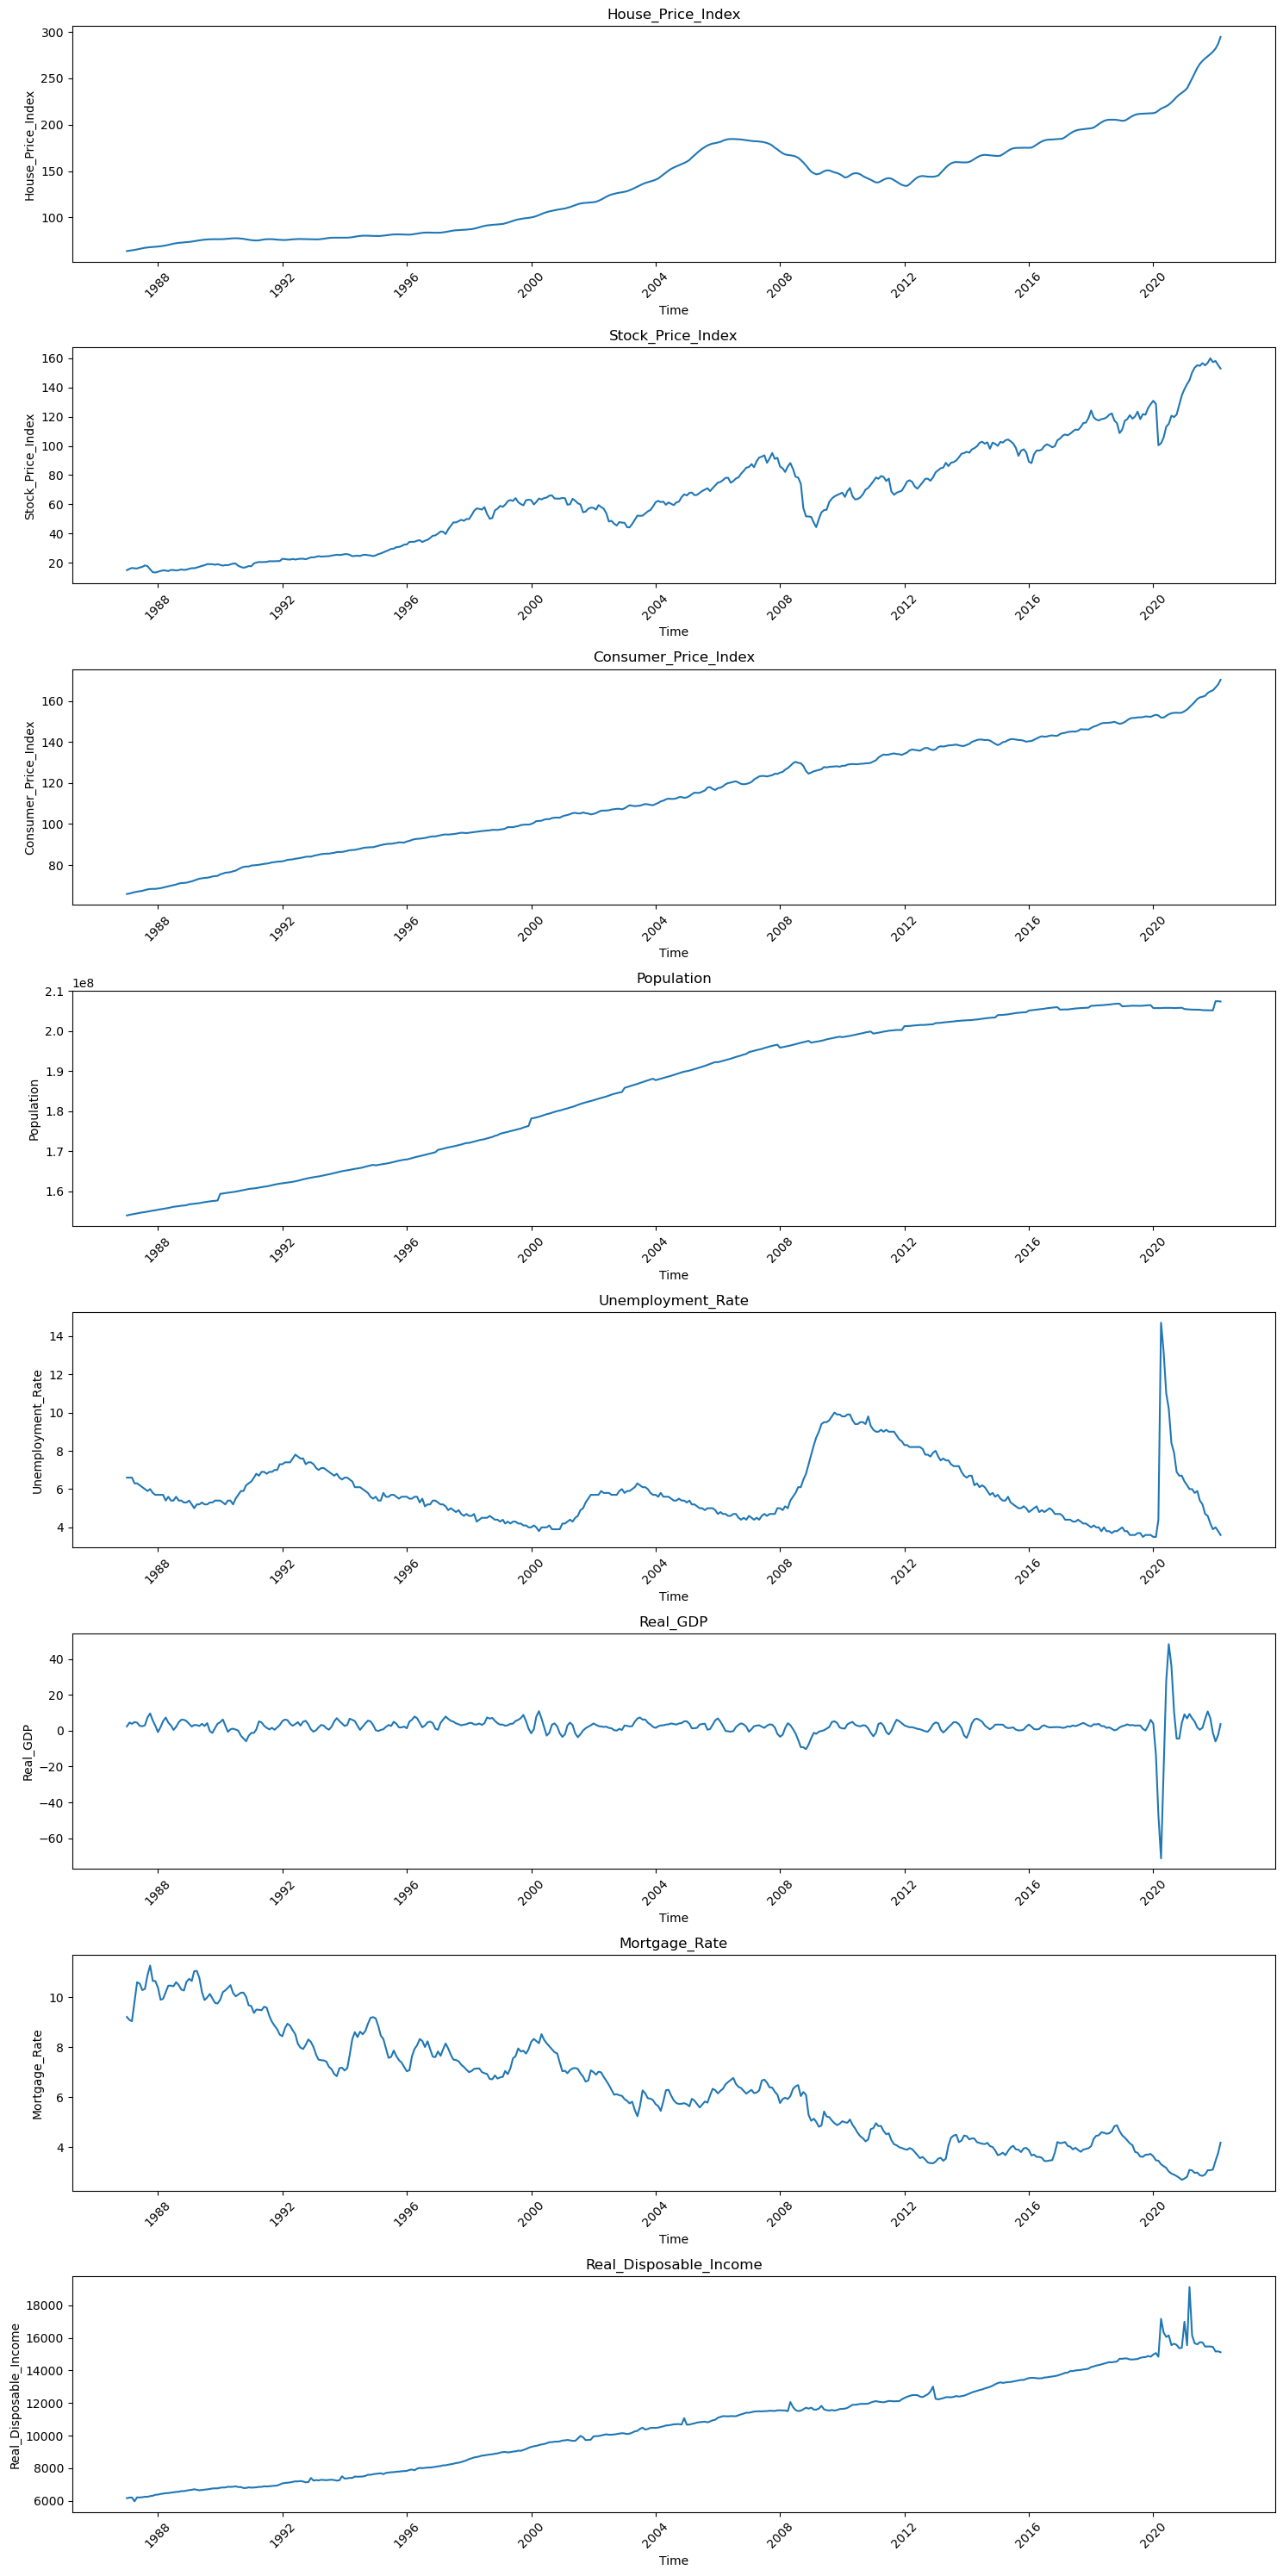

In [8]:
#standardize CPI to the same year as HPI (January 1, 2000)
df['Consumer_Price_Index'] /= df.loc['2000-01-01', 'Consumer_Price_Index']
df['Consumer_Price_Index'] *= 100

#plots of every variable verus time
variables = df.columns
plt.figure(figsize=(15, 30))  
for i, var in enumerate(variables, start=1):
    plt.subplot(len(variables), 1, i)
    plt.plot(df.index, df[var])
    plt.title(var)
    plt.xlabel('Time')
    plt.ylabel(var)
    plt.xticks(rotation=45)
    plt.tight_layout()

plt.show()


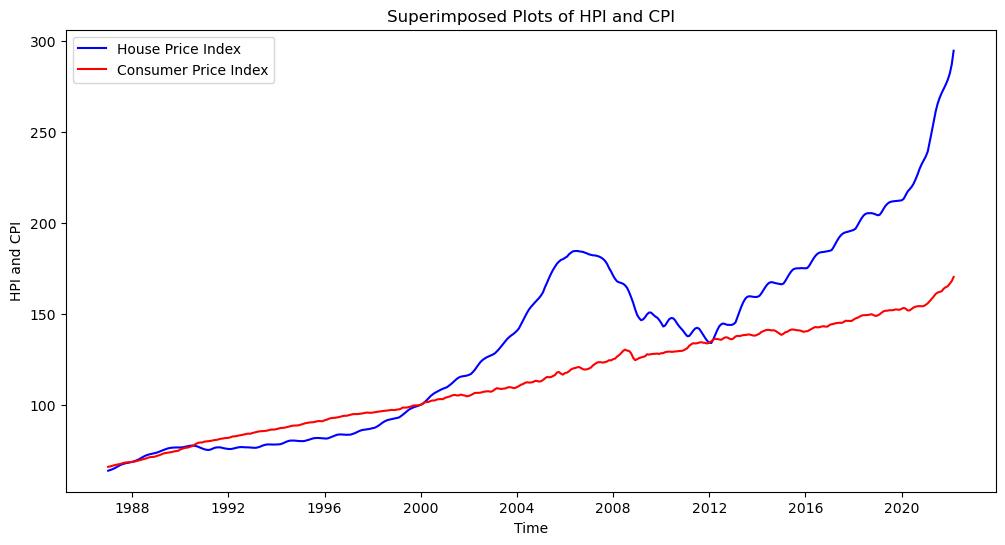

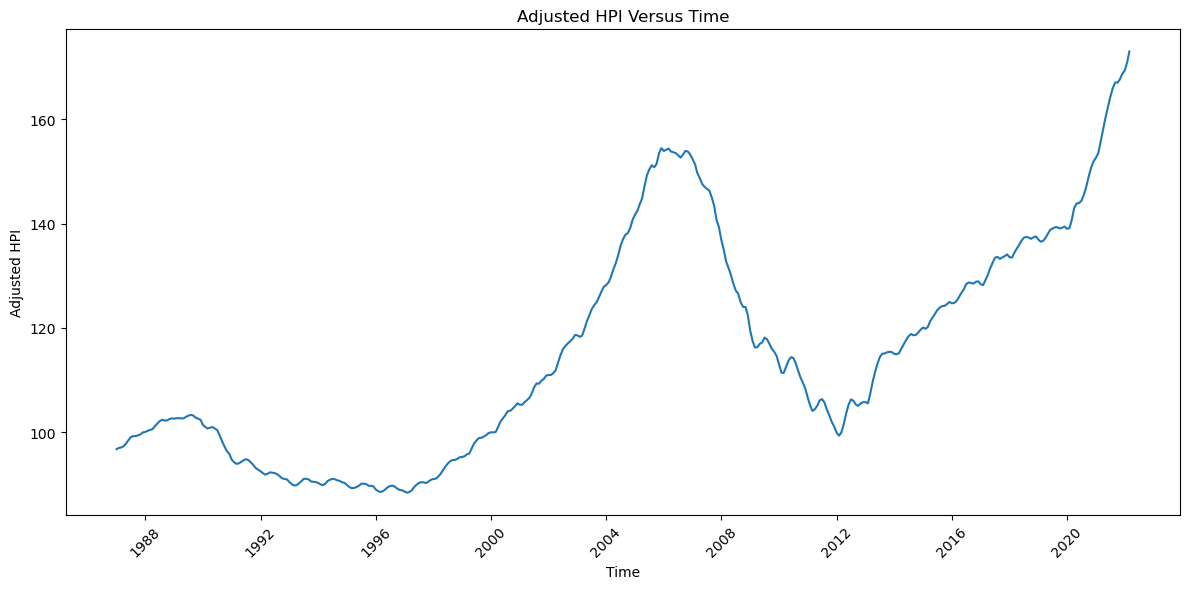

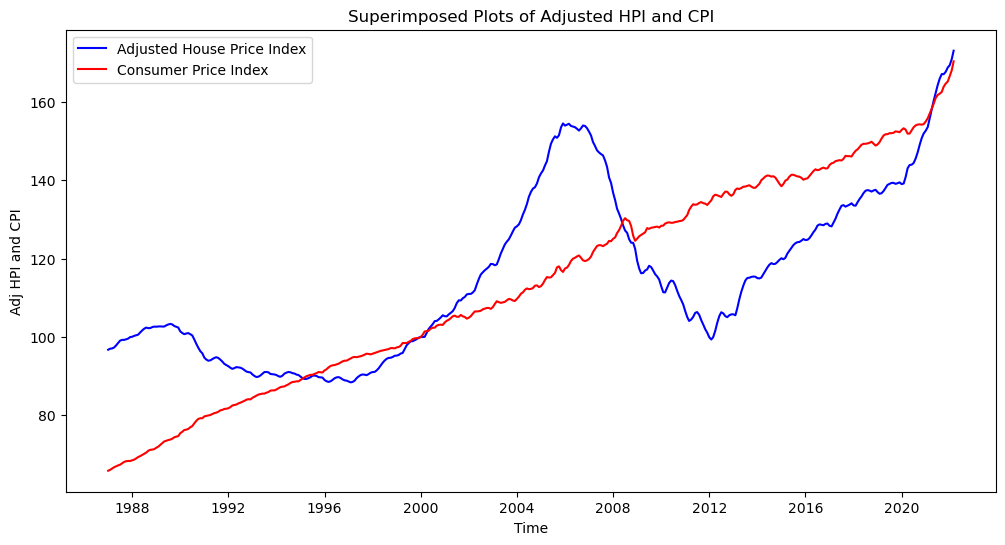

In [9]:
#Plot originial HPI (including inflation bias) against CPI

plt.figure(figsize=(12, 6))

# Plot the first dataset
plt.plot(df.index, df['House_Price_Index'], label='House Price Index', color='blue')

# Plot the second dataset on the same axes
plt.plot(df.index, df['Consumer_Price_Index'], label='Consumer Price Index', color='red')

# Add titles and labels
plt.title('Superimposed Plots of HPI and CPI')
plt.xlabel('Time')
plt.ylabel('HPI and CPI')

# Add a legend
plt.legend()

'''
#Plot HPI versus CPI
plt.figure(figsize=(12, 6))  
plt.plot(df['Consumer_Price_Index'], df['House_Price_Index'])
plt.title('HPI Versus CPI')
plt.xlabel('Consumer Price Index')
plt.ylabel('Housing Price Index')
plt.xticks(rotation=45)
plt.tight_layout()
'''


#divide HPI by CPI to see HPI without inflation bias

df['Adj_House_Price_Index'] = df['House_Price_Index']/ df['Consumer_Price_Index']
df['Adj_House_Price_Index'] *= 100

#Plot Adj_HPI versus time
plt.figure(figsize=(12, 6))  
plt.plot(df.index, df['Adj_House_Price_Index'])
plt.title('Adjusted HPI Versus Time')
plt.xlabel('Time')
plt.ylabel('Adjusted HPI')
plt.xticks(rotation=45)
plt.tight_layout()

#Plot Adj_HPI versus time and CPI versus time to see if Adj_HPI is growing faster than CPI/inflation

plt.figure(figsize=(12, 6))

# Plot the first dataset
plt.plot(df.index, df['Adj_House_Price_Index'], label='Adjusted House Price Index', color='blue')

# Plot the second dataset on the same axes
plt.plot(df.index, df['Consumer_Price_Index'], label='Consumer Price Index', color='red')

# Add titles and labels
plt.title('Superimposed Plots of Adjusted HPI and CPI')
plt.xlabel('Time')
plt.ylabel('Adj HPI and CPI')

# Add a legend
plt.legend()

plt.show()

In [10]:
# changing real gdp from percentage change to actual real gdp, but it will be relative
# to a base year since we do not have the data of actual dollar amount of rgdp
# we will use January 1, 2000 as the base year as before

# pretending rgdp at index -1 is "1" just for simplicity. now calculate real gdp at each date using the percent
# change for that date from the date before. we need to divide each rgdp data point by 12 to change from annual to 
# monthly form


df['Actual_RGDP'] = df['Real_GDP'] / 12

# convert to percents
df['Actual_RGDP'] /= 100

#add 1 to first date to pretend rgdp in index -1 is 1
df.loc['1987-01-01', 'Actual_RGDP'] += 1


#change each Actual_RGDP element to prior element multiplied by (1+current element)

for i in range(1, len(df)):
    df.iloc[i, df.columns.get_loc('Actual_RGDP')] = df.iloc[i-1, df.columns.get_loc('Actual_RGDP')] * (1 + df.iloc[i, df.columns.get_loc('Actual_RGDP')])

#standardize Actual_RGDP to the same year as HPI (January 1, 2000)
df['Actual_RGDP'] /= df.loc['2000-01-01', 'Actual_RGDP']
df['Actual_RGDP'] *= 100

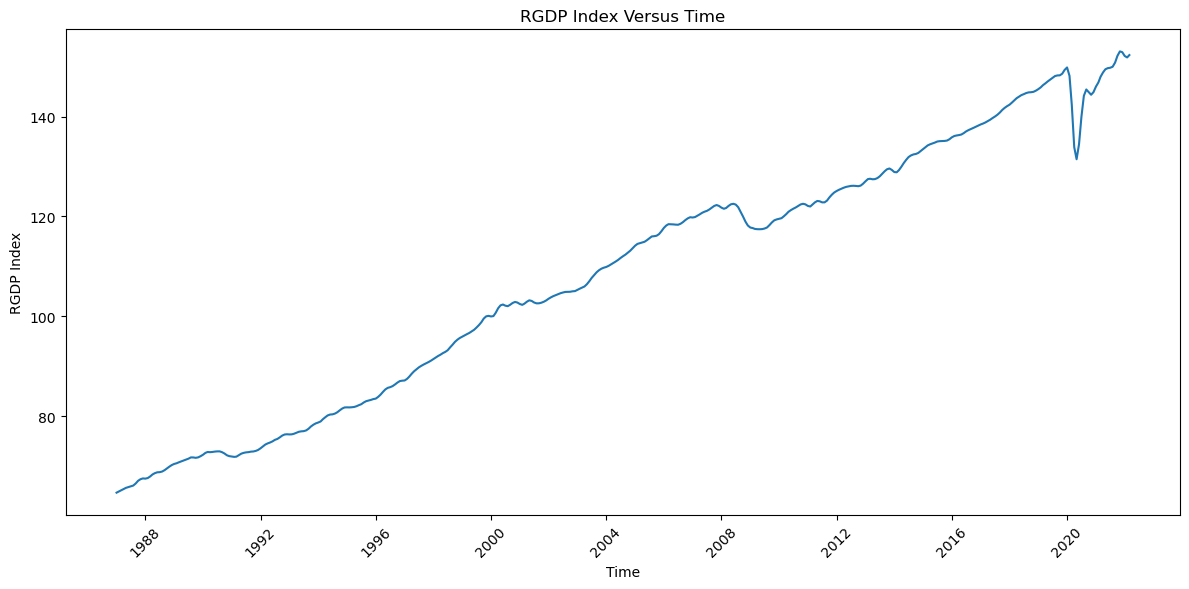

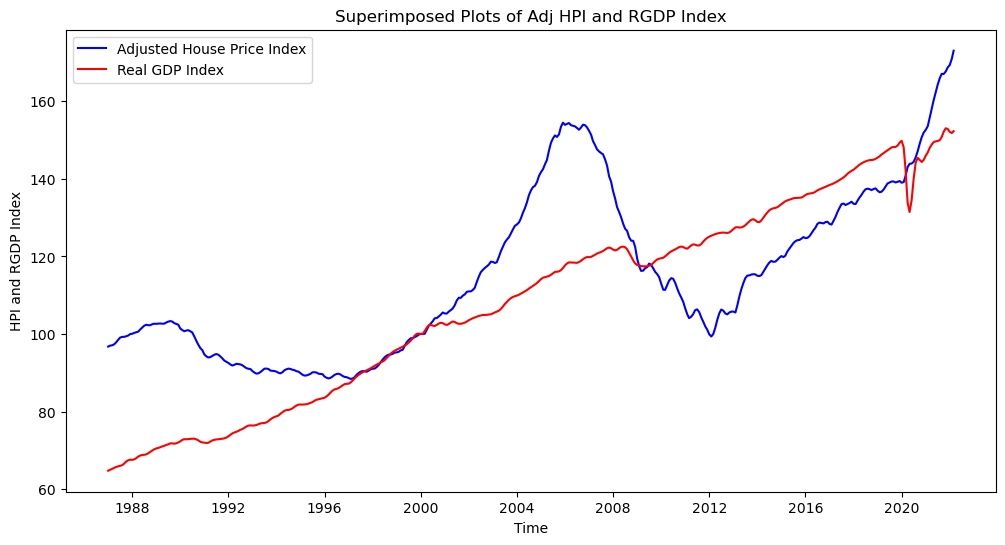

In [11]:
#Plot Actual_RGDP versus time
plt.figure(figsize=(12, 6))  
plt.plot(df.index, df['Actual_RGDP'])
plt.title('RGDP Index Versus Time')
plt.xlabel('Time')
plt.ylabel('RGDP Index')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

'''
#Plot HPI versus Actual_RGDP
plt.figure(figsize=(12, 6))  # Increase the figure size to 15 inches wide by 30 inches tall
plt.plot(df['Actual_RGDP'], df['Adj_House_Price_Index'])
plt.title('Adjusted HPI Versus RGDP Index')
plt.xlabel('RGDP Index')
plt.ylabel('Adjusted Housing Price Index')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()
'''

#Superimpose RGDP index versus time over Adjusted HPI versus time. (Both have same base date for comparing purposes)

plt.figure(figsize=(12, 6))

# Plot the first dataset
plt.plot(df.index, df['Adj_House_Price_Index'], label='Adjusted House Price Index', color='blue')

# Plot the second dataset on the same axes
plt.plot(df.index, df['Actual_RGDP'], label='Real GDP Index', color='red')

# Add titles and labels
plt.title('Superimposed Plots of Adj HPI and RGDP Index')
plt.xlabel('Time')
plt.ylabel('HPI and RGDP Index')

# Add a legend
plt.legend()

# Show the plot
plt.show()

                            OLS Regression Results                            
Dep. Variable:      House_Price_Index   R-squared:                       0.927
Model:                            OLS   Adj. R-squared:                  0.926
Method:                 Least Squares   F-statistic:                     755.2
Date:                Fri, 24 May 2024   Prob (F-statistic):          1.20e-231
Time:                        03:23:13   Log-Likelihood:                -1721.3
No. Observations:                 423   AIC:                             3459.
Df Residuals:                     415   BIC:                             3491.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept               -159

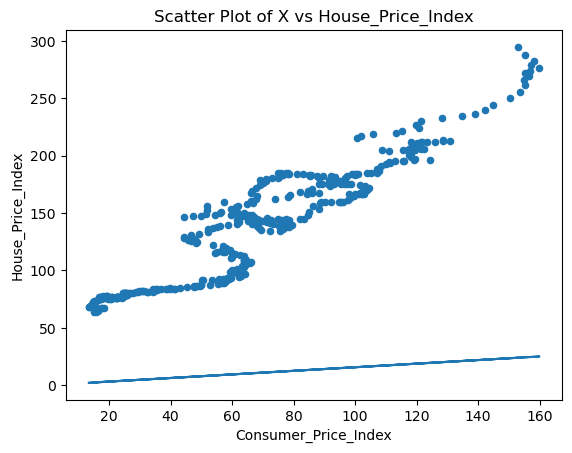

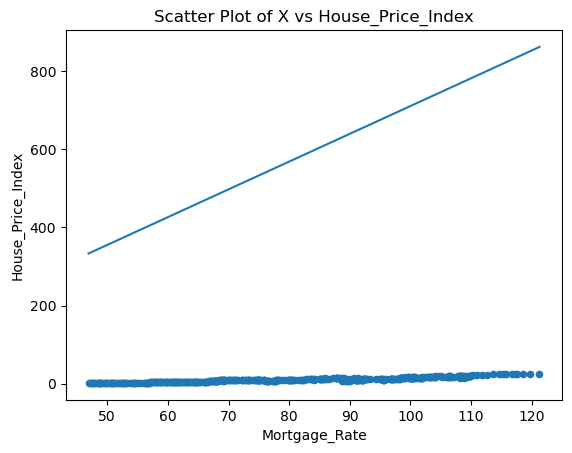

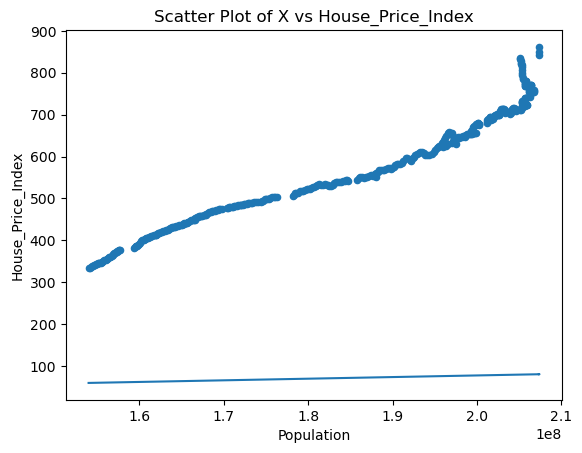

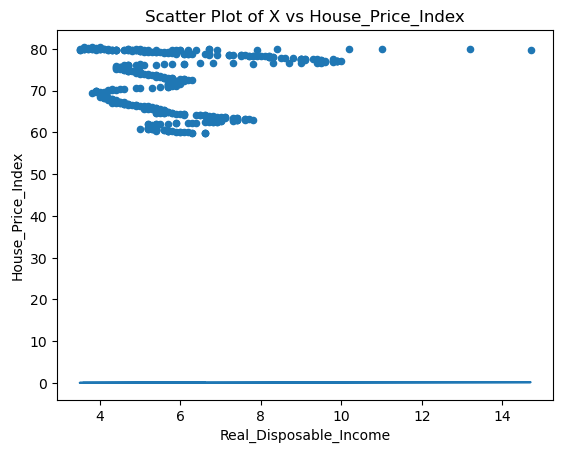

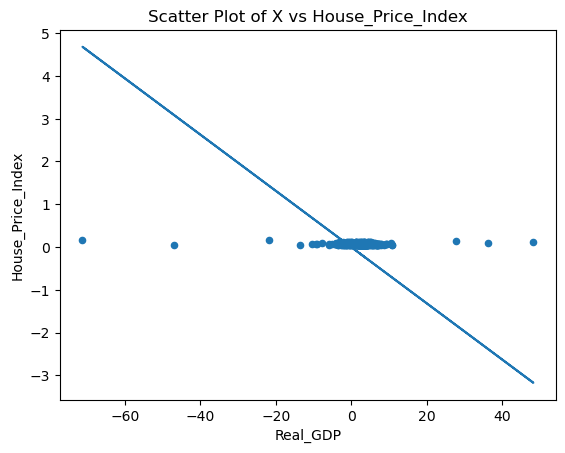

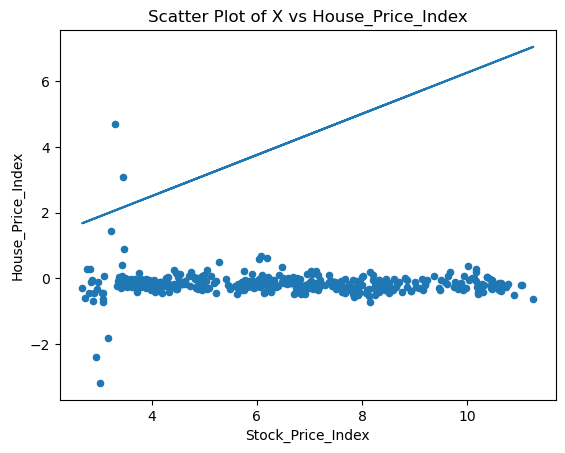

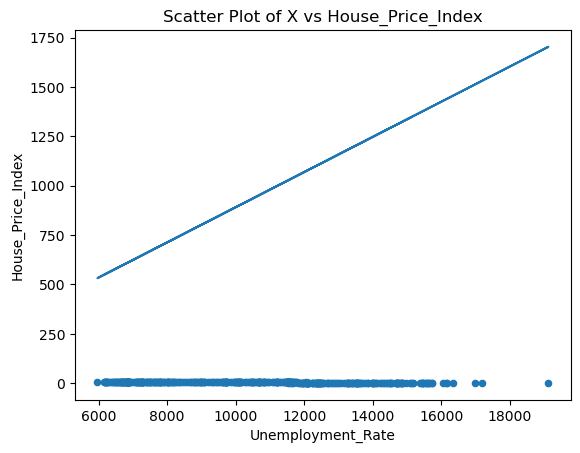

In [12]:
#plots 

import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf

#Data
df = pd.read_csv('Monthly_Macroeconomic_Factors.csv')
df.set_index('Date', inplace=True) # set the date as the index

#Model with all variables
formula = 'House_Price_Index ~ ' + ' + '.join(
    df.columns.difference(['House_Price_Index'])) #get all the columns except for the house price index

model = smf.ols(formula, data=df)
results = model.fit()
print(results.summary())

X = df.drop('House_Price_Index', axis=1)
y = df['House_Price_Index']

X = sm.add_constant(X)

import matplotlib.pyplot as plt
ser = results.params
for i in range(1, len(ser)) :
    x = X[X.columns[i]]
    y = y
    
    plt.scatter(x, y, s=20)
    m = ser.iloc[i]
    y = m * x
    plt.plot(x, y)
    plt.xlabel(ser.index[i])
    plt.ylabel('House_Price_Index')
    plt.title('Scatter Plot of X vs House_Price_Index')
    plt.show()